# Iteration 4

In [2]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, stddev, col, randn, when, lit,sum, mean,row_number, rand, monotonically_increasing_id

from pyspark.sql.window import Window
spark = SparkSession.builder.appName('basics').getOrCreate()

In [3]:
# load the data
df = spark.read.csv('./suicide/suicide_rates_1990-2022.csv', inferSchema=True, header=True)

# 2.Data Understanding

## 2.3 Data Exploration

In [4]:
# describe data
df.printSchema()
print('Index:',df.count())
print('Data columns:',len(df.columns))

root
 |-- RegionCode: string (nullable = true)
 |-- RegionName: string (nullable = true)
 |-- CountryCode: string (nullable = true)
 |-- CountryName: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- AgeGroup: string (nullable = true)
 |-- Generation: string (nullable = true)
 |-- SuicideCount: integer (nullable = true)
 |-- CauseSpecificDeathPercentage: double (nullable = true)
 |-- DeathRatePer100K: double (nullable = true)
 |-- Population: integer (nullable = true)
 |-- GDP: double (nullable = true)
 |-- GDPPerCapita: double (nullable = true)
 |-- GrossNationalIncome: double (nullable = true)
 |-- GNIPerCapita: integer (nullable = true)
 |-- InflationRate: double (nullable = true)
 |-- EmploymentPopulationRatio: double (nullable = true)



Index: 118560
Data columns: 18


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

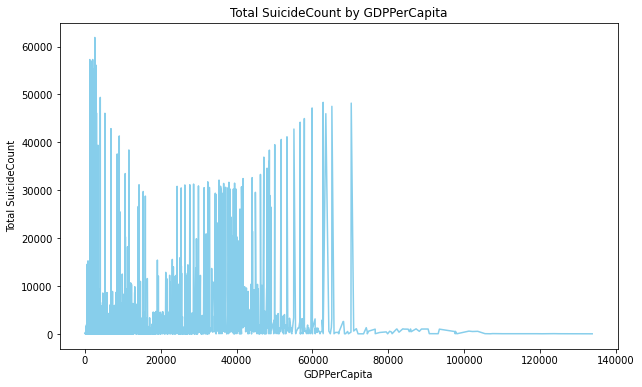

In [12]:
# caculate the sum of SuicideCount with same AgeGroup
gdp = df.groupBy("GDPPerCapita").agg(sum("SuicideCount").alias("Total_SuicideCount"))

# trans to Pandas DataFrame
pandas_df = gdp.toPandas()
pandas_df = pandas_df.sort_values(by="GDPPerCapita")

plt.figure(figsize=(10, 6))
plt.plot(pandas_df["GDPPerCapita"], pandas_df["Total_SuicideCount"], color='skyblue')
plt.xlabel('GDPPerCapita')
plt.ylabel('Total SuicideCount')
plt.title('Total SuicideCount by GDPPerCapita')
plt.show()

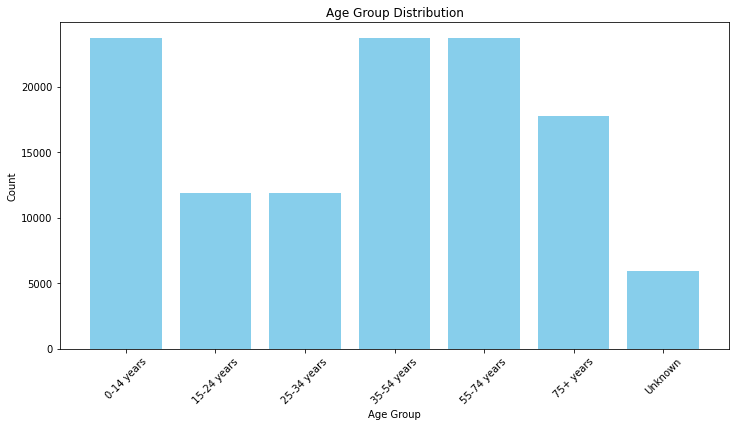

In [9]:
age_group_counts = df.groupBy("AgeGroup").agg(count("*").alias("count"))

# trans to Pandas DataFrame
pandas_age_group_counts = age_group_counts.toPandas()
pandas_age_group_counts = pandas_age_group_counts.sort_values(by="AgeGroup")

# plot histogram
plt.figure(figsize=(12, 6))
plt.bar(pandas_age_group_counts["AgeGroup"], pandas_age_group_counts["count"], color='skyblue')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Age Group Distribution')
plt.xticks(rotation=45)
plt.show()


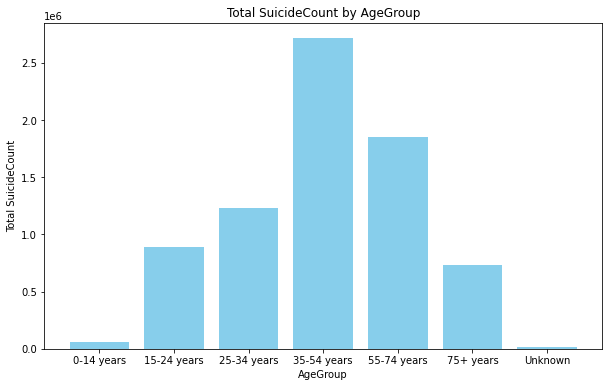

In [7]:
# caculate the sum of SuicideCount with same AgeGroup
aggregated_df = df.groupBy("AgeGroup").agg(sum("SuicideCount").alias("Total_SuicideCount"))

# trans to Pandas DataFrame
pandas_df = aggregated_df.toPandas()
pandas_df = pandas_df.sort_values(by="AgeGroup")

plt.figure(figsize=(10, 6))
plt.bar(pandas_df["AgeGroup"], pandas_df["Total_SuicideCount"], color='skyblue')
plt.xlabel('AgeGroup')
plt.ylabel('Total SuicideCount')
plt.title('Total SuicideCount by AgeGroup')
plt.show()

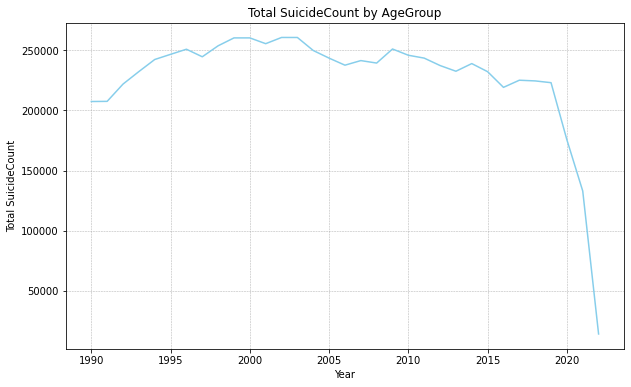

In [15]:
# caculate the sum of SuicideCount with same AgeGroup
year = df.groupBy("Year").agg(sum("SuicideCount").alias("Total_SuicideCount"))

# trans to Pandas DataFrame
pandas_df = year.toPandas()
pandas_df = pandas_df.sort_values(by="Year")

plt.figure(figsize=(10, 6))
plt.plot(pandas_df["Year"], pandas_df["Total_SuicideCount"], color='skyblue')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Year')
plt.ylabel('Total SuicideCount')
plt.title('Total SuicideCount by AgeGroup')
plt.show()

## 2.4 Verifying Data Quality

In [18]:
df.show(10)

+----------+----------+-----------+-----------+----+----+-----------+----------------+------------+----------------------------+----------------+----------+-------------+------------+-------------------+------------+-------------+-------------------------+
|RegionCode|RegionName|CountryCode|CountryName|Year| Sex|   AgeGroup|      Generation|SuicideCount|CauseSpecificDeathPercentage|DeathRatePer100K|Population|          GDP|GDPPerCapita|GrossNationalIncome|GNIPerCapita|InflationRate|EmploymentPopulationRatio|
+----------+----------+-----------+-----------+----+----+-----------+----------------+------------+----------------------------+----------------+----------+-------------+------------+-------------------+------------+-------------+-------------------------+
|        EU|    Europe|        ALB|    Albania|1992|Male| 0-14 years|Generation Alpha|           0|                         0.0|             0.0|   3247039|6.521749908E8| 200.8522198|      9.061842123E8|        1740|  226.0054213

In [19]:
# missing value
null_counts = df.select([sum(col(column).isNull().cast("int")).alias(column) for column in df.columns])
null_counts.show()

+----------+----------+-----------+-----------+----+---+--------+----------+------------+----------------------------+----------------+----------+----+------------+-------------------+------------+-------------+-------------------------+
|RegionCode|RegionName|CountryCode|CountryName|Year|Sex|AgeGroup|Generation|SuicideCount|CauseSpecificDeathPercentage|DeathRatePer100K|Population| GDP|GDPPerCapita|GrossNationalIncome|GNIPerCapita|InflationRate|EmploymentPopulationRatio|
+----------+----------+-----------+-----------+----+---+--------+----------+------------+----------------------------+----------------+----------+----+------------+-------------------+------------+-------------+-------------------------+
|         0|         0|          0|          0|   0|  0|       0|         0|         464|                        4289|           10664|      5920|7240|        7240|               9960|       10760|        14460|                    11120|
+----------+----------+-----------+-----------+-

In [35]:
round(df.dropna().count() / df.count() * 100, 2)

75.07

# 3.Data Preparation
## 3.1 Data selection

In [6]:
df_drop = df.drop('RegionCode', 'CountryCode', 'Generation', 'CauseSpecificDeathPercentage')

df_drop.show(10)

+----------+-----------+----+----+-----------+------------+----------------+----------+-------------+------------+-------------------+------------+-------------+-------------------------+
|RegionName|CountryName|Year| Sex|   AgeGroup|SuicideCount|DeathRatePer100K|Population|          GDP|GDPPerCapita|GrossNationalIncome|GNIPerCapita|InflationRate|EmploymentPopulationRatio|
+----------+-----------+----+----+-----------+------------+----------------+----------+-------------+------------+-------------------+------------+-------------+-------------------------+
|    Europe|    Albania|1992|Male| 0-14 years|           0|             0.0|   3247039|6.521749908E8| 200.8522198|      9.061842123E8|        1740|  226.0054213|                   45.315|
|    Europe|    Albania|1992|Male| 0-14 years|           0|             0.0|   3247039|6.521749908E8| 200.8522198|      9.061842123E8|        1740|  226.0054213|                   45.315|
|    Europe|    Albania|1992|Male| 0-14 years|           0| 

In [7]:
df_drop.printSchema()

root
 |-- RegionName: string (nullable = true)
 |-- CountryName: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- AgeGroup: string (nullable = true)
 |-- SuicideCount: integer (nullable = true)
 |-- DeathRatePer100K: double (nullable = true)
 |-- Population: integer (nullable = true)
 |-- GDP: double (nullable = true)
 |-- GDPPerCapita: double (nullable = true)
 |-- GrossNationalIncome: double (nullable = true)
 |-- GNIPerCapita: integer (nullable = true)
 |-- InflationRate: double (nullable = true)
 |-- EmploymentPopulationRatio: double (nullable = true)



## 3.2 Clean Data

### Null value

In [14]:
null_counts = df_drop.select([sum(col(column).isNull().cast("int")).alias(column) for column in df_drop.columns])
null_counts.show()

+----------+-----------+----+---+--------+------------+----------------+----------+----+------------+-------------------+------------+-------------+-------------------------+
|RegionName|CountryName|Year|Sex|AgeGroup|SuicideCount|DeathRatePer100K|Population| GDP|GDPPerCapita|GrossNationalIncome|GNIPerCapita|InflationRate|EmploymentPopulationRatio|
+----------+-----------+----+---+--------+------------+----------------+----------+----+------------+-------------------+------------+-------------+-------------------------+
|         0|          0|   0|  0|       0|           0|           10664|         0|7240|        7240|               9960|       10760|        14460|                    11120|
+----------+-----------+----+---+--------+------------+----------------+----------+----+------------+-------------------+------------+-------------+-------------------------+



In [8]:
# fill null value for SuicideCount and Population
mean_values = df_drop.select(mean("SuicideCount").alias("mean_SuicideCount"), mean("Population").alias("mean_Population")).collect()[0]

df_drop = df_drop.na.fill({"SuicideCount": mean_values[0], "Population": mean_values[1]})

In [9]:
# use the normal distribution to randomly fill
# caculate mean and stand dev
stats = df_drop.select(
    [avg(c).alias(f"mean_{c}") for c in df_drop.columns] +
    [stddev(c).alias(f"stddev_{c}") for c in df_drop.columns]
).collect()[0]


mean_stddev_dict = {col: (stats[f"mean_{col}"], stats[f"stddev_{col}"]) for col in df_drop.columns}

# fill null value in each column
for col_name in df_drop.columns:
    mean = mean_stddev_dict[col_name][0]
    stddev = mean_stddev_dict[col_name][1]
    
    # normal distribution
    random_col = randn() * stddev + mean
    df_drop = df_drop.withColumn(
        col_name,
        when(col(col_name).isNull(), random_col).otherwise(col(col_name))
    )



24/05/22 05:07:48 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [10]:
null_counts = df_drop.select([sum(col(column).isNull().cast("int")).alias(column) for column in df_drop.columns])
null_counts.show()

+----------+-----------+----+---+--------+------------+----------------+----------+---+------------+-------------------+------------+-------------+-------------------------+
|RegionName|CountryName|Year|Sex|AgeGroup|SuicideCount|DeathRatePer100K|Population|GDP|GDPPerCapita|GrossNationalIncome|GNIPerCapita|InflationRate|EmploymentPopulationRatio|
+----------+-----------+----+---+--------+------------+----------------+----------+---+------------+-------------------+------------+-------------+-------------------------+
|         0|          0|   0|  0|       0|           0|               0|         0|  0|           0|                  0|           0|            0|                        0|
+----------+-----------+----+---+--------+------------+----------------+----------+---+------------+-------------------+------------+-------------+-------------------------+



### Extrem value

In [22]:
df_drop.select('GDP').describe().show()

+-------+--------------------+
|summary|                 GDP|
+-------+--------------------+
|  count|              115818|
|   mean|5.298619790672822E11|
| stddev|1.648351474874181E12|
|    min|        2.19762963E8|
|    max|          2.33151E13|
+-------+--------------------+



In [11]:
df_drop.filter(df_drop['GDP']<0).count()

2845

In [12]:
df_drop = df_drop.filter(df_drop['GDP']>=0)

# check again
df_drop.select('GDP').describe().show()

+-------+--------------------+
|summary|                 GDP|
+-------+--------------------+
|  count|              115715|
|   mean|5.265979921662773...|
| stddev|1.646661658732558...|
|    min|        2.19762963E8|
|    max|          2.33151E13|
+-------+--------------------+



## 3.3 Constructing/Deriving a New Feature and Data Integration

In [13]:
aggregated_df = df_drop.groupBy("RegionName", "Year", "Sex", "AgeGroup", "Population", 
                           "GDP", "GDPPerCapita", "GrossNationalIncome", "GNIPerCapita", 
                           "InflationRate", "EmploymentPopulationRatio").agg(
    sum("SuicideCount").alias("SuicideCount"),
    avg("DeathRatePer100K").alias("DeathRatePer100K")
)
aggregated_df.show(10)

+--------------------+------+-------+-----------+-----------+---------------+------------+-------------------+------------+------------------+-------------------------+------------+------------------+
|          RegionName|  Year|    Sex|   AgeGroup| Population|            GDP|GDPPerCapita|GrossNationalIncome|GNIPerCapita|     InflationRate|EmploymentPopulationRatio|SuicideCount|  DeathRatePer100K|
+--------------------+------+-------+-----------+-----------+---------------+------------+-------------------+------------+------------------+-------------------------+------------+------------------+
|              Europe|2008.0|   Male|    Unknown|  2947314.0|1.2881352894E10| 4370.539716|    1.1892990139E10|      8270.0|       3.320870904|                   46.243|         0.0| 4.287348752168986|
|Central and South...|2006.0|   Male|35-54 years|3.9476851E7|     2.32557E11| 5890.978002|         2.15445E11|     14410.0| 35.07626310186311|                   55.571|       153.0|       12.91502

In [26]:
print('Index:',aggregated_df.count())
null_counts = aggregated_df.select([sum(col(column).isNull().cast("int")).alias(column) for column in aggregated_df.columns])
null_counts.show()

Index: 53795


+----------+----+---+--------+----------+---+------------+-------------------+------------+-------------+-------------------------+------------+----------------+
|RegionName|Year|Sex|AgeGroup|Population|GDP|GDPPerCapita|GrossNationalIncome|GNIPerCapita|InflationRate|EmploymentPopulationRatio|SuicideCount|DeathRatePer100K|
+----------+----+---+--------+----------+---+------------+-------------------+------------+-------------+-------------------------+------------+----------------+
|         0|   0|  0|       0|         0|  0|           0|                  0|           0|            0|                        0|           0|               0|
+----------+----+---+--------+----------+---+------------+-------------------+------------+-------------+-------------------------+------------+----------------+



## 3.4.Data Integration

In [14]:
df1, df2 = aggregated_df.randomSplit([0.5, 0.5])

In [29]:
print('Index of df1:',df1.count())
print('Data columns of df1:',len(df1.columns))

print('Index of df2:',df2.count())
print('Data columns of df2:',len(df2.columns))

Index of df1: 26966
Data columns of df1: 13


Index of df2: 26829
Data columns of df2: 13


In [47]:
merged_df = df1.union(df2)

merged_df.describe().show()

null_counts = merged_df.select([sum(col(column).isNull().cast("int")).alias(column) for column in merged_df.columns])
null_counts.show()

+-------+----------+------------------+-------+----------+--------------------+--------------------+------------------+--------------------+-------------------+------------------+-------------------------+------------------+------------------+
|summary|RegionName|              Year|    Sex|  AgeGroup|          Population|                 GDP|      GDPPerCapita| GrossNationalIncome|       GNIPerCapita|     InflationRate|EmploymentPopulationRatio|      SuicideCount|  DeathRatePer100K|
+-------+----------+------------------+-------+----------+--------------------+--------------------+------------------+--------------------+-------------------+------------------+-------------------------+------------------+------------------+
|  count|     53692|             53692|  53692|     53692|               53692|               53692|             53692|               53692|              53692|             53692|                    53692|             53692|             53692|
|   mean|      null|2004

+----------+----+---+--------+----------+---+------------+-------------------+------------+-------------+-------------------------+------------+----------------+
|RegionName|Year|Sex|AgeGroup|Population|GDP|GDPPerCapita|GrossNationalIncome|GNIPerCapita|InflationRate|EmploymentPopulationRatio|SuicideCount|DeathRatePer100K|
+----------+----+---+--------+----------+---+------------+-------------------+------------+-------------+-------------------------+------------+----------------+
|         0|   0|  0|       0|         0|  0|           0|                  0|           0|            0|                        0|           0|               0|
+----------+----+---+--------+----------+---+------------+-------------------+------------+-------------+-------------------------+------------+----------------+



In [33]:
merged_df.show(10)

+----------+------+------+-----------+-----------+--------------------+-------------------+--------------------+------------------+-------------------+-------------------------+------------+------------------+
|RegionName|  Year|   Sex|   AgeGroup| Population|                 GDP|       GDPPerCapita| GrossNationalIncome|      GNIPerCapita|      InflationRate|EmploymentPopulationRatio|SuicideCount|  DeathRatePer100K|
+----------+------+------+-----------+-----------+--------------------+-------------------+--------------------+------------------+-------------------+-------------------------+------------+------------------+
|    Africa|1990.0|Female|55-74 years|2.4561843E7|1.170519911563672...| -6845.512203970717|-2.31056893338480...|13120.847203462063|-175.71143154412871|         57.7030581249253|         1.0|       12.98701299|
|    Africa|1990.0|Female|55-74 years|2.4561843E7|1.446733291329557...| 15338.353385048655|-1.31955687017426...|31722.058334860252|  6.032938937221472|        5

In [20]:
merged_df.printSchema()

merged_df = merged_df.withColumn("SuicideCount", col("SuicideCount").cast("int"))
# after modify
merged_df.printSchema()

root
 |-- RegionName: string (nullable = true)
 |-- Year: double (nullable = true)
 |-- Sex: string (nullable = true)
 |-- AgeGroup: string (nullable = true)
 |-- Population: double (nullable = true)
 |-- GDP: double (nullable = true)
 |-- GDPPerCapita: double (nullable = true)
 |-- GrossNationalIncome: double (nullable = true)
 |-- GNIPerCapita: double (nullable = true)
 |-- InflationRate: double (nullable = true)
 |-- EmploymentPopulationRatio: double (nullable = true)
 |-- SuicideCount: integer (nullable = true)
 |-- DeathRatePer100K: double (nullable = true)



In [44]:
merged_df.groupBy("Sex").count().show()

24/05/21 11:45:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/21 11:45:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/21 11:45:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/21 11:45:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+------+-----+
|   Sex|count|
+------+-----+
|Female|27293|
|  Male|26418|
+------+-----+



In [48]:
df_with_id = merged_df.withColumn("ID", monotonically_increasing_id())

unknown_count = df_with_id.filter(df_with_id["Sex"] == "Unknown").count()

window_spec = Window.orderBy("ID")
df_with_index = df_with_id.withColumn("index", row_number().over(window_spec))

half_count = unknown_count // 2
merged_df = df_with_index.withColumn(
    "Sex",
    when(
        (col("Sex") == "Unknown") & (col("index") <= half_count),
        "Male"
    ).when(
        (col("Sex") == "Unknown") & (col("index") > half_count),
        "Female"
    ).otherwise(col("Sex"))
).drop("ID").drop("index")


In [44]:
merged_df.groupBy("Sex").count().show()

24/05/22 06:26:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 06:26:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 06:26:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+------+-----+
|   Sex|count|
+------+-----+
|Female|27294|
|  Male|26398|
+------+-----+



In [45]:
merged_df.printSchema()

root
 |-- RegionName: string (nullable = true)
 |-- Year: double (nullable = true)
 |-- Sex: string (nullable = true)
 |-- AgeGroup: string (nullable = true)
 |-- Population: double (nullable = true)
 |-- GDP: double (nullable = true)
 |-- GDPPerCapita: double (nullable = true)
 |-- GrossNationalIncome: double (nullable = true)
 |-- GNIPerCapita: double (nullable = true)
 |-- InflationRate: double (nullable = true)
 |-- EmploymentPopulationRatio: double (nullable = true)
 |-- SuicideCount: double (nullable = true)
 |-- DeathRatePer100K: double (nullable = true)



In [28]:
#####################################################################################################################################
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

In [30]:
# StringIndexer 和 OneHotEncoder 对每个类别变量进行处理
indexer1 = StringIndexer(inputCol="RegionName", outputCol="RegionNameIndex")
encoder1 = OneHotEncoder(inputCol="RegionNameIndex", outputCol="RegionNameVec")

indexer2 = StringIndexer(inputCol="AgeGroup", outputCol="AgeGroupIndex")
encoder2 = OneHotEncoder(inputCol="AgeGroupIndex", outputCol="AgeGroupVec")

# 使用 Pipeline 简化数据处理流程
pipeline = Pipeline(stages=[indexer1, encoder1, indexer2, encoder2])

model = pipeline.fit(merged_df)
encoded_df = model.transform(merged_df)
encoded_df.printSchema()

root
 |-- RegionName: string (nullable = true)
 |-- Year: double (nullable = true)
 |-- Sex: string (nullable = true)
 |-- AgeGroup: string (nullable = true)
 |-- Population: double (nullable = true)
 |-- GDP: double (nullable = true)
 |-- GDPPerCapita: double (nullable = true)
 |-- GrossNationalIncome: double (nullable = true)
 |-- GNIPerCapita: double (nullable = true)
 |-- InflationRate: double (nullable = true)
 |-- EmploymentPopulationRatio: double (nullable = true)
 |-- SuicideCount: integer (nullable = true)
 |-- DeathRatePer100K: double (nullable = true)
 |-- RegionNameIndex: double (nullable = false)
 |-- RegionNameVec: vector (nullable = true)
 |-- AgeGroupIndex: double (nullable = false)
 |-- AgeGroupVec: vector (nullable = true)



In [32]:
encoded_df.select(encoded_df['AgeGroupVec']).show(5)

+-------------+
|  AgeGroupVec|
+-------------+
|(6,[2],[1.0])|
|(6,[3],[1.0])|
|(6,[3],[1.0])|
|(6,[1],[1.0])|
|(6,[2],[1.0])|
+-------------+
only showing top 5 rows



# 4. Data Transformation


In [25]:
from pyspark.sql.functions import log1p
import seaborn as sns
import pandas as pd

In [33]:
# calculate SuicideCount correlation
colum = ['Year', 'Population', 
    'GDP', 'GDPPerCapita', 'GrossNationalIncome', 'GNIPerCapita', 
    'InflationRate', 'EmploymentPopulationRatio']

target_column = 'SuicideCount'
correlations = {column: merged_df.stat.corr(column, target_column) for column in colum}


sorted_correlations = pd.Series(correlations).sort_values(ascending=False)

# result
print(sorted_correlations)

Population                   0.468118
GDP                          0.401676
GrossNationalIncome          0.392094
GDPPerCapita                 0.083244
GNIPerCapita                 0.056450
EmploymentPopulationRatio    0.035251
InflationRate                0.021287
Year                         0.009510
dtype: float64


## 4.2 Data Projection

Text(0.5, 0, 'Population')

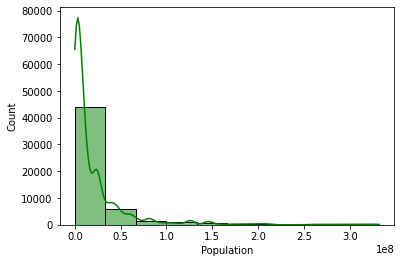

In [24]:
population_data = merged_df.select("Population").rdd.flatMap(lambda x: x).collect()

# Population hist plot
sns.histplot(population_data, bins=10, kde=True, color='green')
plt.xlabel('Population')

Text(0.5, 0, 'GDP')

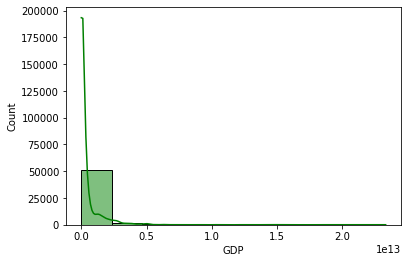

In [36]:
sns.histplot(merged_df.select("GDP").rdd.flatMap(lambda x: x).collect(), bins=10, kde=True, color='green')
plt.xlabel('GDP')

In [ ]:
sns.histplot(merged_df.select("SuicideCount").rdd.flatMap(lambda x: x).collect(), bins=10, kde=True, color='green')
plt.xlabel('SuicideCount')

In [ ]:
sns.histplot(merged_df.select("GNIPerCapita").rdd.flatMap(lambda x: x).collect(), bins=10, kde=True, color='green')
plt.xlabel('GNIPerCapita')

In [ ]:
sns.histplot(merged_df.select("GrossNationalIncome").rdd.flatMap(lambda x: x).collect(), bins=10, kde=True, color='green')
plt.xlabel('GrossNationalIncome')

In [ ]:
sns.histplot(merged_df.select("EmploymentPopulationRatio").rdd.flatMap(lambda x: x).collect(), bins=10, kde=True, color='green')
plt.xlabel('EmploymentPopulationRatio')

In [ ]:
sns.histplot(merged_df.select("DeathRatePer100K").rdd.flatMap(lambda x: x).collect(), bins=10, kde=True, color='green')
plt.xlabel('DeathRatePer100K')

In [ ]:
sns.histplot(merged_df.select("GDPPerCapita").rdd.flatMap(lambda x: x).collect(), bins=10, kde=True, color='green')
plt.xlabel('GDPPerCapita')

Text(0.5, 0, 'InflationRate')

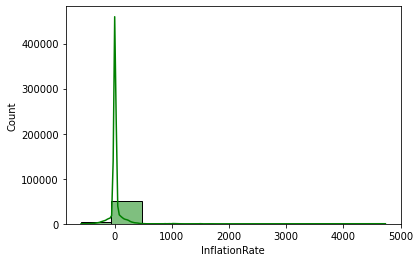

In [39]:
sns.histplot(merged_df.select("InflationRate").rdd.flatMap(lambda x: x).collect(), bins=10, kde=True, color='green')
plt.xlabel('InflationRate')

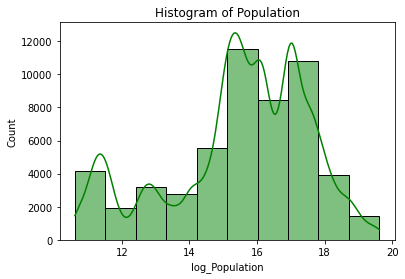

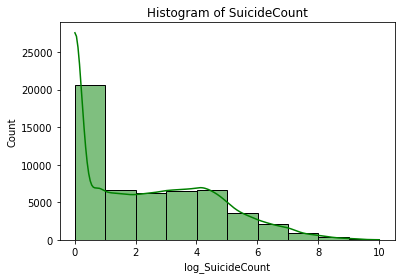

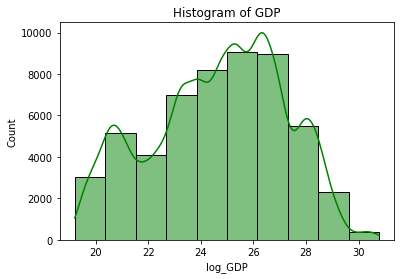

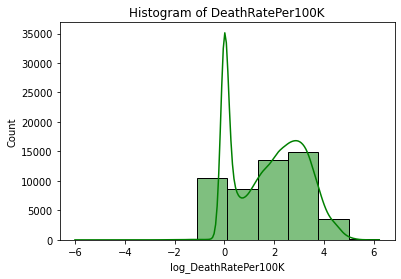

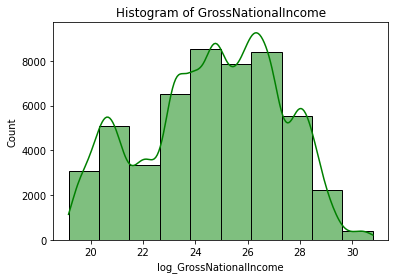

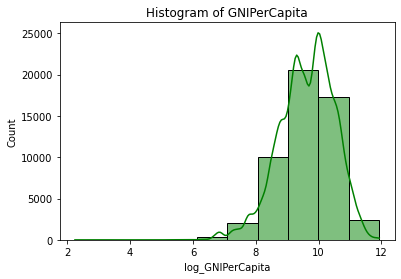

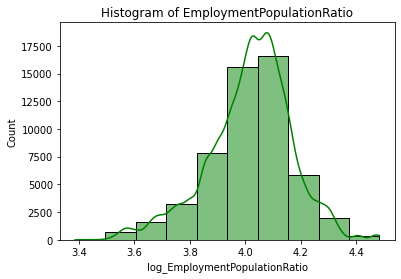

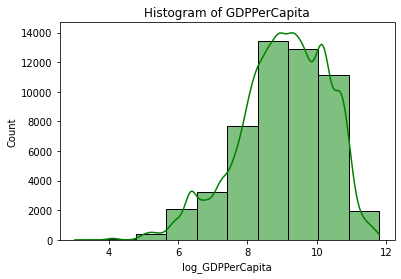

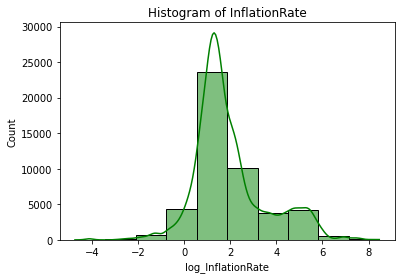

In [49]:
columns_to_transform = ['Population', 'SuicideCount', 'GDP', 'DeathRatePer100K',
                        'GrossNationalIncome', 'GNIPerCapita', 'EmploymentPopulationRatio', 'GDPPerCapita','InflationRate']

for column in columns_to_transform:
    merged_df = merged_df.withColumn(column, log1p(col(column)))

for column in columns_to_transform:
    plt.figure()
    column_data = merged_df.select(column).rdd.flatMap(lambda x: x).collect()
    # plot histogram
    sns.histplot(column_data, bins=10, kde=True, color='green')
    plt.title(f'Histogram of {column}')
    plt.xlabel(f'log_{column}')
    plt.show()

In [40]:
merged_df.printSchema()

root
 |-- RegionName: string (nullable = true)
 |-- Year: double (nullable = true)
 |-- Sex: string (nullable = true)
 |-- AgeGroup: string (nullable = true)
 |-- Population: double (nullable = true)
 |-- GDP: double (nullable = true)
 |-- GDPPerCapita: double (nullable = true)
 |-- GrossNationalIncome: double (nullable = true)
 |-- GNIPerCapita: double (nullable = true)
 |-- InflationRate: double (nullable = true)
 |-- EmploymentPopulationRatio: double (nullable = true)
 |-- SuicideCount: double (nullable = true)
 |-- DeathRatePer100K: double (nullable = true)

